In [1]:
import scanpy as sc
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)
%matplotlib inline

In [2]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_57/2174054843.py:8: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
%%R
library(tidyverse)
library(dyno)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: dynfeature
Loading required package: dynguidelines
Loading required package: dynmethods
Loading required package: dynplot
Loading required package: dynwrap
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


# Loading Data

In [4]:
%%R
data <- readRDS("mesoderm-development_loh (1).rds")
str(data)

List of 21
 $ id                   : chr "real/gold/mesoderm-development_loh"
 $ cell_ids             : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
 $ cell_info            :'data.frame':	504 obs. of  4 variables:
  ..$ cell_id     : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ Run         : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ LibraryName : chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
  ..$ milestone_id: chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
 $ source               : chr "real/gold"
 $ normalisation_info   :List of 3
  ..$ has_spike          : logi TRUE
  ..$ has_mito           : logi TRUE
  ..$ normalisation_steps: tibble [6 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ type     : chr [1:6] "original" "cell_quality_filtering" "feature_expression_filtering" "normalisation" ...
  .. ..$ nfeatures: int [1:6] 58480 58480 36347 36347 8772 8772
  .. ..$ ncells   : int [1:6] 651 504 504

In [5]:
%%R
data$normalisation_info

$has_spike
[1] TRUE

$has_mito
[1] TRUE

$normalisation_steps
# A tibble: 6 × 3
  type                          nfeatures ncells
  <chr>                             <int>  <int>
1 original                          58480    651
2 cell_quality_filtering            58480    504
3 feature_expression_filtering      36347    504
4 normalisation                     36347    504
5 feature_variability_filtering      8772    504
6 final_filtering                    8772    504



In [6]:
%%R
counts <- data$counts
expression <- data$expression

In [7]:
%%R
dataset <- wrap_expression(
  expression = expression,
  counts = counts
)

In [8]:
%%R
names(data$prior_information)

 [1] "start_milestones"      "start_id"              "end_milestones"       
 [4] "end_id"                "groups_id"             "groups_network"       
 [7] "features_id"           "groups_n"              "timecourse_continuous"
[10] "timecourse_discrete"   "start_n"               "end_n"                


In [9]:
%%R --o grouping
print(data$prior_information$start_id)
print(data$prior_information$start_milestones)
grouping <- data$grouping
# grouping <- ifelse(grouping == "H7hESC", "H7hESC", "temp")
# grouping <- ifelse(names(grouping) == "SRR3952356", "start", "temp")
str(grouping)

[1] "SRR3952356"
[1] "H7hESC"
 Named chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
 - attr(*, "names")= chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...


In [10]:
pd.Series(grouping).value_counts()

H7_dreived_D2.25_Smtmrs     84
H7_derived_DLL1pPXM         73
H7_derived_APS              62
H7_derived_Sclrtm           62
H7_derived_D5CntrlDrmmtm    59
H7hESC                      54
H7_derived_D2LtM            48
H7_derived_ESMT             40
H7_derived_MPS              22
Name: count, dtype: int64

In [11]:
%%R
dataset <- add_prior_information(
    dataset,
    start_id = data$prior_information$start_id
)
dataset <- add_grouping(
    dataset,
    data$grouping
)

In [12]:
%%R
print(dataset$prior_information)

$start_id
[1] "SRR3952356"



# Slingshot

In [13]:
%%R
slingshot_model <- infer_trajectory(dataset, ti_slingshot(), give_priors = c("start_id"))

1
1


You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: tislingshot
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'tislingshot' from a github remote, the SHA1 (65248eca) has not changed since last install.
  Use `force = TRUE` to force installation


In [14]:
%%R
names(slingshot_model)

 [1] "id"                          "cell_ids"                   
 [3] "cell_info"                   "feature_ids"                
 [5] "feature_info"                "milestone_ids"              
 [7] "milestone_network"           "divergence_regions"         
 [9] "milestone_percentages"       "progressions"               
[11] "trajectory_type"             "directed"                   
[13] "dimred"                      "dimred_milestones"          
[15] "dimred_segment_progressions" "dimred_segment_points"      


In [15]:
%%R
slingshot_model <- add_grouping(slingshot_model, grouping)

Loading required namespace: RColorBrewer


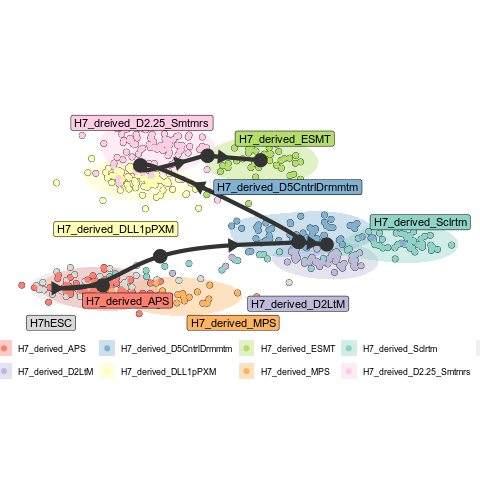

In [16]:
%%R
plot_dimred(slingshot_model, color_cells=c("grouping"), color_density="grouping")
# trajectory isn't starting from the start milestone

# Scorpius

In [17]:
%%R
scorpius_model <- infer_trajectory(dataset, ti_scorpius(), give_priors = c("start_id"))

Following packages have to be installed: SCORPIUS
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'SCORPIUS' from a github remote, the SHA1 (a0a97907) has not changed since last install.
  Use `force = TRUE` to force installation


In [18]:
%%R
names(scorpius_model)

 [1] "id"                          "cell_ids"                   
 [3] "cell_info"                   "feature_ids"                
 [5] "feature_info"                "milestone_ids"              
 [7] "milestone_network"           "divergence_regions"         
 [9] "milestone_percentages"       "progressions"               
[11] "pseudotime"                  "trajectory_type"            
[13] "directed"                    "dimred"                     
[15] "dimred_milestones"           "dimred_segment_progressions"
[17] "dimred_segment_points"      


Coloring by grouping


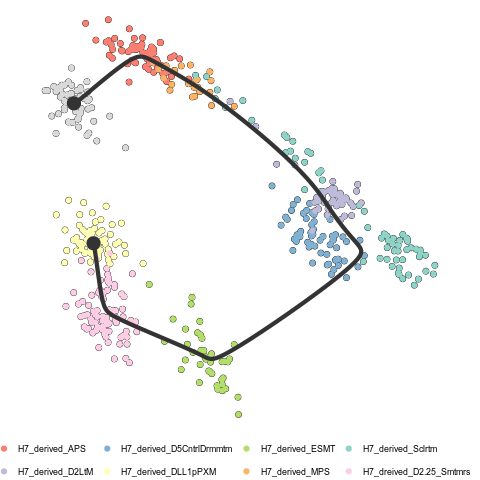

In [19]:
%%R
plot_dimred(scorpius_model, grouping=grouping)

# PAGA

In [20]:
%%R
paga_model <- infer_trajectory(dataset, ti_paga(), give_priors = c("start_id"))

Error in file(con, "r") : cannot open the connection
In addition: Warning message:
In file(con, "r") :
  cannot open file '/tmp/RtmpO7sgjt/file3931adc889//tmpfile': No such file or directory
Error in file(con, "r") : cannot open the connection


RInterpreterError: Failed to parse and evaluate line 'paga_model <- infer_trajectory(dataset, ti_paga(), give_priors = c("start_id"))\n'.
R error message: 'Error in file(con, "r") : cannot open the connection'
R stdout:
Error in file(con, "r") : cannot open the connection
In addition: Warning message:
In file(con, "r") :
  cannot open file '/tmp/RtmpO7sgjt/file3931adc889//tmpfile': No such file or directory

# Angle

In [21]:
%%R
angle_model <- infer_trajectory(dataset, ti_angle(), give_priors = c("start_id"))

Error in file(con, "r") : cannot open the connection
In addition: Warning message:
In file(con, "r") :
  cannot open file '/tmp/RtmpO7sgjt/file397fb1dfa4//tmpfile': No such file or directory
Error in file(con, "r") : cannot open the connection


RInterpreterError: Failed to parse and evaluate line 'angle_model <- infer_trajectory(dataset, ti_angle(), give_priors = c("start_id"))\n'.
R error message: 'Error in file(con, "r") : cannot open the connection'
R stdout:
Error in file(con, "r") : cannot open the connection
In addition: Warning message:
In file(con, "r") :
  cannot open file '/tmp/RtmpO7sgjt/file397fb1dfa4//tmpfile': No such file or directory

In [22]:
ls -ld /tmp

drwxrwxrwt 1 root root 4096 Feb 17 18:56 /tmp/


In [23]:
ls -ld /tmp/RtmpO7sgjt

drwx------ 4 root root 4096 Feb 17 18:56 /tmp/RtmpO7sgjt/


In [24]:
%%R
paga_tree_model <- infer_trajectory(dataset, ti_paga_tree(), give_priors = c("start_id"))

v0.9.9.06: Pulling from dynverse/ti_paga_tree
6f2f362378c5: Already exists
23028c55282c: Already exists
d0356fc9da6d: Already exists
e67c3352be2f: Already exists
11a33a33bcd9: Already exists
99cedbd08ad3: Already exists
32ac39911b07: Already exists
690f37b4f11b: Already exists
3dd4d7c3fbf7: Already exists
e61ed39364c4: Already exists
5cc62a86e7e3: Already exists
b905a92924b6: Already exists
19f3e7edf6c6: Already exists
c2fe14888f44: Already exists
ee1c365fb2b7: Already exists
f36370b85e60: Already exists
55178b261b7d: Already exists
c330d18bed49: Already exists
fbce06413c54: Already exists
02334cb066ed: Pulling fs layer
33076a48618d: Pulling fs layer
8228e3ab3634: Pulling fs layer
008aeef74fb3: Pulling fs layer
305ece989e59: Pulling fs layer
008aeef74fb3: Waiting
305ece989e59: Waiting
02334cb066ed: Verifying Checksum
02334cb066ed: Download complete
02334cb066ed: Pull complete
008aeef74fb3: Verifying Checksum
008aeef74fb3: Download complete
305ece989e59: Download complete
8228e3ab3634: 

RInterpreterError: Failed to parse and evaluate line 'paga_tree_model <- infer_trajectory(dataset, ti_paga_tree(), give_priors = c("start_id"))\n'.
R error message: 'Error in file(con, "r") : cannot open the connection'
R stdout:
Error in file(con, "r") : cannot open the connection
In addition: Warning message:
In file(con, "r") :
  cannot open file '/tmp/RtmpO7sgjt/file395587b625//tmpfile': No such file or directory

In [25]:
%%R
wanderlust_model <- infer_trajectory(dataset, ti_wanderlust(), give_priors = c("start_id"))

v0.9.9.01: Pulling from dynverse/ti_wanderlust
844c33c7e6ea: Already exists
4f11e4e30170: Already exists
a9724dff2655: Already exists
f5f3a048c9c3: Already exists
a53c4db932de: Already exists
bd5da474b8ba: Already exists
be9b916e18e7: Already exists
b8b469f67972: Already exists
e33132a1a81b: Already exists
32bd550d2fc1: Already exists
a828ddf00b38: Already exists
d97023e2f782: Already exists
2cbdcd87b58f: Pulling fs layer
51ee6f464655: Pulling fs layer
50116fa0c9b6: Pulling fs layer
637660a9ca4f: Pulling fs layer
e84e980d416e: Pulling fs layer
396ed4d9649b: Pulling fs layer
3b4e50657540: Pulling fs layer
677cd562dcf4: Pulling fs layer
c89b7c95d3e1: Pulling fs layer
637660a9ca4f: Waiting
e84e980d416e: Waiting
396ed4d9649b: Waiting
677cd562dcf4: Waiting
c89b7c95d3e1: Waiting
50116fa0c9b6: Verifying Checksum
50116fa0c9b6: Download complete
2cbdcd87b58f: Verifying Checksum
2cbdcd87b58f: Download complete
2cbdcd87b58f: Pull complete
637660a9ca4f: Verifying Checksum
637660a9ca4f: Download co

RInterpreterError: Failed to parse and evaluate line 'wanderlust_model <- infer_trajectory(dataset, ti_wanderlust(), give_priors = c("start_id"))\n'.
R error message: 'Error in file(con, "r") : cannot open the connection'
R stdout:
Error in file(con, "r") : cannot open the connection
In addition: Warning message:
In file(con, "r") :
  cannot open file '/tmp/RtmpO7sgjt/file394fcabe7b//tmpfile': No such file or directory

In [26]:
%%R
wishbone_model <- infer_trajectory(dataset, ti_wishbone(), give_priors = c("start_id"))

v0.9.9.01: Pulling from dynverse/ti_wishbone
844c33c7e6ea: Already exists
4f11e4e30170: Already exists
a9724dff2655: Already exists
f5f3a048c9c3: Already exists
a53c4db932de: Already exists
bd5da474b8ba: Already exists
be9b916e18e7: Already exists
b8b469f67972: Already exists
e33132a1a81b: Already exists
32bd550d2fc1: Already exists
a828ddf00b38: Already exists
d97023e2f782: Already exists
2cbdcd87b58f: Already exists
51ee6f464655: Already exists
50116fa0c9b6: Already exists
637660a9ca4f: Already exists
e84e980d416e: Already exists
396ed4d9649b: Already exists
3b4e50657540: Already exists
ef74c0899c06: Pulling fs layer
aee816ad5302: Pulling fs layer
aee816ad5302: Download complete
ef74c0899c06: Verifying Checksum
ef74c0899c06: Download complete
ef74c0899c06: Pull complete
aee816ad5302: Pull complete
Digest: sha256:a0e966cab31d0b7cd11579bab511c245e8a520c24bc43125a587e8b8c174991e
Status: Downloaded newer image for dynverse/ti_wishbone:v0.9.9.01
docker.io/dynverse/ti_wishbone:v0.9.9.01
Er

RInterpreterError: Failed to parse and evaluate line 'wishbone_model <- infer_trajectory(dataset, ti_wishbone(), give_priors = c("start_id"))\n'.
R error message: 'Error in file(con, "r") : cannot open the connection'
R stdout:
Error in file(con, "r") : cannot open the connection
In addition: Warning message:
In file(con, "r") :
  cannot open file '/tmp/RtmpO7sgjt/file39704bc505//tmpfile': No such file or directory